<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Part 4 : Model Evaluation & Result

### In this notebook , there are 3 main sections:

4.1. Stacking model 

4.2. Model Evaluation 

4.3. Result and Recommendation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import warnings
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,accuracy_score,classification_report,precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

SEED = 42


In [5]:
# Import data from Part 3
with open('./datasets/Z_train.pickle','rb') as read_file:
    Z_train = pickle.load(read_file)

with open('./datasets/y_train.pickle','rb') as read_file:
    y_train = pickle.load(read_file)

with open('./datasets/Z_test.pickle','rb') as read_file:
    Z_test = pickle.load(read_file)

with open('./datasets/y_test.pickle','rb') as read_file:
    y_test = pickle.load(read_file)

with open('./datasets/id.pickle','rb') as read_file:
    id = pickle.load(read_file)


print(y_train.shape,Z_train.shape)
print(y_test.shape,Z_test.shape)

(15822,) (15822, 232)
(2089,) (2089, 232)


## 4.1 Stacking

### The evaluation metrics for the models are `Acuracy` and `ROC-AUC`. We also take the `Accuracy score generalisation` of the models into consideration to ensure the prediction result is robust for all the '`unseen`' result.

```
The models that selected in this project are:
a. RandomForrest
b. Gradient Boosting
c. XGBoosting
d. LGBoosting
e. Neural Network
f. Stacking (best 3 models from model above)
```

In [6]:
#define function for stacking of models

#Sklearn package - Randomboost, Gradientboost
class SklearnWrapper(object):
    def __init__(self, clf, seed = 42, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

#XGboost
class XgbWrapper(object):
    def __init__(self, seed = 42, params = None):
        self.seed = seed
        self.param = params
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        #dtrain = xgb.DMatrix(x_train, label=y_train)
        #self.gbdt = xgb.train(self.param, dtrain, self.nrounds)
        self.gbdt = xgb.XGBClassifier(**self.param)
        self.gbdt.fit(x_train, y_train,verbose=True,eval_metric='auc',eval_set=[(Z_test,y_test)])

    def predict(self, x):
        #return self.gbdt.predict(xgb.DMatrix(x))
        return self.gbdt.predict_proba(x)[:,1]

#LightGBM
class LgbWrapper(object):
    def __init__(self, clf, seed = 42, params = None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

#Tensorflow - Neural NETWORK
class NNWrapper(object):
    def __init__(self, seed = 42, params = None):
        self.seed = seed
        self.param = params

    def train(self, x_train, y_train):
        self.model = tf.keras.models.load_model('./datasets/NN_model.h5')

    def predict(self, x):
        return self.model.predict(x,batch_size=512).squeeze()


In [7]:
#The parameters are tuned in Part 3

xgb_params = {
    'learning_rate': 0.2,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'n_estimators': 300,
    'tree_method': 'hist',
    #'nrounds': 200
}


lightgbm_params = {
    'objective': 'binary',
    'n_estimators':500,
    'learning_rate':0.01,
    'num_leaves':50,
    'max_depth':35,
    'reg_alpha':0.3, 
}

gb_params = {
    'n_estimators': 400,
    'max_depth': 10,
    'min_samples_split': 2,
    'max_features': 'log2',
    'learning_rate': 0.15,
}

rf_params = {
    'n_estimators': 1600,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
}


In [8]:
# To stack the models, we also do cross validation using 2 folds to get the out-of-fold predictions

NFOLDS = 2
NROWS = None
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

# Function to generate test and train dataset from base 1st level model for stacking
def get_oof(clf):
    oof_train = np.zeros((Z_train.shape[0],))
    oof_test = np.zeros((Z_test.shape[0],))
    oof_test_skf = np.empty((NFOLDS, Z_test.shape[0]))
    

    for i, (train_index, test_index) in enumerate(kf.split(Z_train)):
        x_tr = Z_train[train_index]
        y_tr = y_train[train_index]
        x_te = Z_train[test_index]

        clf.train(x_tr, y_tr)
 
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(Z_test)
        

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [9]:
# Initiate the models

xg = XgbWrapper(seed = SEED, params = xgb_params)
lg = LgbWrapper(clf = lgb.LGBMClassifier, seed = SEED, params = lightgbm_params)
gb = SklearnWrapper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
rf = SklearnWrapper(clf = RandomForestClassifier, seed = SEED, params = rf_params)
nn = NNWrapper(seed = SEED, params = None)

In [10]:
# Get the out-of-fold predictions from each model
xg_train, xg_test = get_oof(xg)
lg_train, lg_test = get_oof(lg)
gb_train, gb_test = get_oof(gb)
rf_train, rf_test = get_oof(rf)
nn_train, nn_test = get_oof(nn)

[0]	validation_0-auc:0.74604
[1]	validation_0-auc:0.76725
[2]	validation_0-auc:0.77436
[3]	validation_0-auc:0.77939
[4]	validation_0-auc:0.78624
[5]	validation_0-auc:0.79153
[6]	validation_0-auc:0.80424
[7]	validation_0-auc:0.80476
[8]	validation_0-auc:0.80581
[9]	validation_0-auc:0.80703
[10]	validation_0-auc:0.80645
[11]	validation_0-auc:0.80941
[12]	validation_0-auc:0.80909
[13]	validation_0-auc:0.81012
[14]	validation_0-auc:0.80974
[15]	validation_0-auc:0.81346
[16]	validation_0-auc:0.81497
[17]	validation_0-auc:0.81495
[18]	validation_0-auc:0.81758
[19]	validation_0-auc:0.81805
[20]	validation_0-auc:0.81745
[21]	validation_0-auc:0.81776
[22]	validation_0-auc:0.81749
[23]	validation_0-auc:0.81964
[24]	validation_0-auc:0.81933
[25]	validation_0-auc:0.82027
[26]	validation_0-auc:0.82207
[27]	validation_0-auc:0.82199
[28]	validation_0-auc:0.82221
[29]	validation_0-auc:0.82220
[30]	validation_0-auc:0.82241
[31]	validation_0-auc:0.82240
[32]	validation_0-auc:0.82247
[33]	validation_0-au

In [11]:
# Evaluation of the base first level models

# The ROC-AUC score for the base model on test data
print('The ROC-AUC score for the base model on test data')
print("XG-CV: {}".format(roc_auc_score(y_test, xg_test)))
print("LG-CV: {}".format(roc_auc_score(y_test, lg_test)))
print("GB-CV: {}".format(roc_auc_score(y_test, gb_test)))
print("RF-CV: {}".format(roc_auc_score(y_test, rf_test)))
print("NN-CV: {}".format(roc_auc_score(y_test, nn_test)))

# The Accuracy score for the base model on test data
print('The Accuracy score for the base model on test data')
print("XG-CV: {}".format(accuracy_score(y_test, xg_test>0.5)))
print("LG-CV: {}".format(accuracy_score(y_test, lg_test>0.5)))
print("GB-CV: {}".format(accuracy_score(y_test, gb_test>0.5)))
print("RF-CV: {}".format(accuracy_score(y_test, rf_test>0.5)))
print("NN-CV: {}".format(accuracy_score(y_test, nn_test>0.5)))

The ROC-AUC score for the base model on test data
XG-CV: 0.8387546511093757
LG-CV: 0.8415246451375809
GB-CV: 0.8333386926363177
RF-CV: 0.8302701088704121
NN-CV: 0.8209173595479812
The Accuracy score for the base model on test data
XG-CV: 0.9286740067017711
LG-CV: 0.9143130684538057
GB-CV: 0.9310674964097654
RF-CV: 0.7884155098133078
NN-CV: 0.8654858784107229


---
### From the 1st level model result, the top 3 performers are XGBoost, LGBoost and Gradientboost.
#### In the section below, the predictions of the models are combined to pipe-lined to the `meta model', the 2nd level of stacking method

In [12]:
#Combine the base models for evaluation purpose only
X_train = np.concatenate(( xg_train, lg_train, gb_train, rf_train, nn_train), axis=1)
X_test = np.concatenate(( xg_test, lg_test, gb_test,rf_test, nn_test), axis=1)

In [13]:
#Correlation matrix of the top 3 base models
X_train_stack = np.concatenate(( xg_train, lg_train, gb_train), axis=1)
X_test_stack = np.concatenate(( xg_test, lg_test, gb_test), axis=1)

#Initialte the Meta model
meta = LogisticRegression(random_state=SEED)
meta.fit(X_train_stack,y_train)

#Generate prediction for the meta model
y_pred_prob = meta.predict_proba(X_test_stack)[:,1]
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

In [14]:
#First glance on the stacking result

tn, fp, fn, tp = confusion_matrix(y_train, meta.predict(X_train_stack)).ravel()
accuracy_train = (tp+tn)/(tp+tn+fp+fn)
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, meta.predict(X_test_stack)).ravel()
accuracy_test = (tp1+tn1)/(tp1+tn1+fp1+fn1)
generalisation = 100*(accuracy_train - accuracy_test) / accuracy_train
auc_score = roc_auc_score(y_test, y_pred_prob)
print("Train Accuracy: {}".format(accuracy_train))
print("Test Accuracy: {}".format(accuracy_test))
print("Accuracy Generalisation: {}%".format(generalisation))
print("AUC-score for test data: {}".format(auc_score))

Train Accuracy: 0.9600556187586904
Test Accuracy: 0.9334609861177597
Accuracy Generalisation: 2.7701137435471015%
AUC-score for test data: 0.8441430474527998


## 4.2 Models Evaluation
#### The stacking of the top models show some overall improvement compare to the base model and having good generalisation of  <5% for `Accuracy` matrics
Next, all models will be compared on their metrics
1. Accuracy
2. ROC-AUC
3. Accuracy Generalisation (target <5%)
4. ROC curve

In [15]:
# Generate the table for the evaluation of the models
# initiate the evaluation dataset
eval = {}
# The metrics for stacking model
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
eval['stacking'] = accuracy_test,generalisation,auc_score,fpr,tpr,precision,recall

# The list of base models
ls = ['xg', 'lg', 'gb', 'rf', 'nn']
for i in range(len(ls)):
    
    acc_train = accuracy_score(y_train, X_train[:,i]>0.5)
    acc_test = accuracy_score(y_test, X_test[:,i]>0.5)
    generalisation_ls = 100*(acc_train - acc_test) / acc_train
    auc = roc_auc_score(y_test, X_test[:,i])
    
    # results for plot(ROC, FPR) evaluation
    fpr, tpr, _ = roc_curve(y_test,  X_test[:,i])
    precision, recall, _ = precision_recall_curve(y_test, X_test[:,i])

    # store the results in the dictionary
    eval[ls[i]] = acc_test,generalisation_ls,auc,fpr,tpr,precision,recall


eval_df = pd.DataFrame(eval,index=['accuracy','generalisation','auc score','fpr','tpr','Precision','Recall']).T
eval_df['model'] = eval_df.index
eval_df = eval_df.reset_index(drop=True)
eval_df.head(6)


accuracy generalisation auc score  \
0  0.933461       2.770114  0.844143   
1  0.928674       2.808043  0.838755   
2  0.914313       3.352075  0.841525   
3  0.931067       2.987488  0.833339   
4  0.788416       8.566223   0.83027   
5  0.865486       8.427728  0.820917   

                                                 fpr  \
0  [0.0, 0.0, 0.0005053057099545225, 0.0015159171...   
1  [0.0, 0.001010611419909045, 0.0010106114199090...   
2  [0.0, 0.0, 0.0005053057099545225, 0.0015159171...   
3  [0.0, 0.0005053057099545225, 0.001010611419909...   
4  [0.0, 0.0, 0.001010611419909045, 0.00202122283...   
5  [0.0, 0.0005053057099545225, 0.001010611419909...   

                                                 tpr  \
0  [0.0, 0.00909090909090909, 0.00909090909090909...   
1  [0.0, 0.0, 0.00909090909090909, 0.009090909090...   
2  [0.0, 0.00909090909090909, 0.00909090909090909...   
3  [0.0, 0.0, 0.0, 0.03636363636363636, 0.0363636...   
4  [0.0, 0.00909090909090909, 0.00909090909090909...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.01818181818181818,...   

                                           Precision  \
0  [0.052656773575873624, 0.05268199233716475, 0....   
1  [0.052656773575873624, 0.05268199233716475, 0....   
2  [0.052656773575873624, 0.05270723526593196, 0....   
3  [0.052656773575873624, 0.05268199233716475, 0....   
4  [0.052656773575873624, 0.05268199233716475, 0....   
5  [0.052656773575873624, 0.05268199233716475, 0....   

                                              Recall     model  
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  stacking  
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        xg  
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        lg  
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        gb  
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        rf  
5  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...        nn

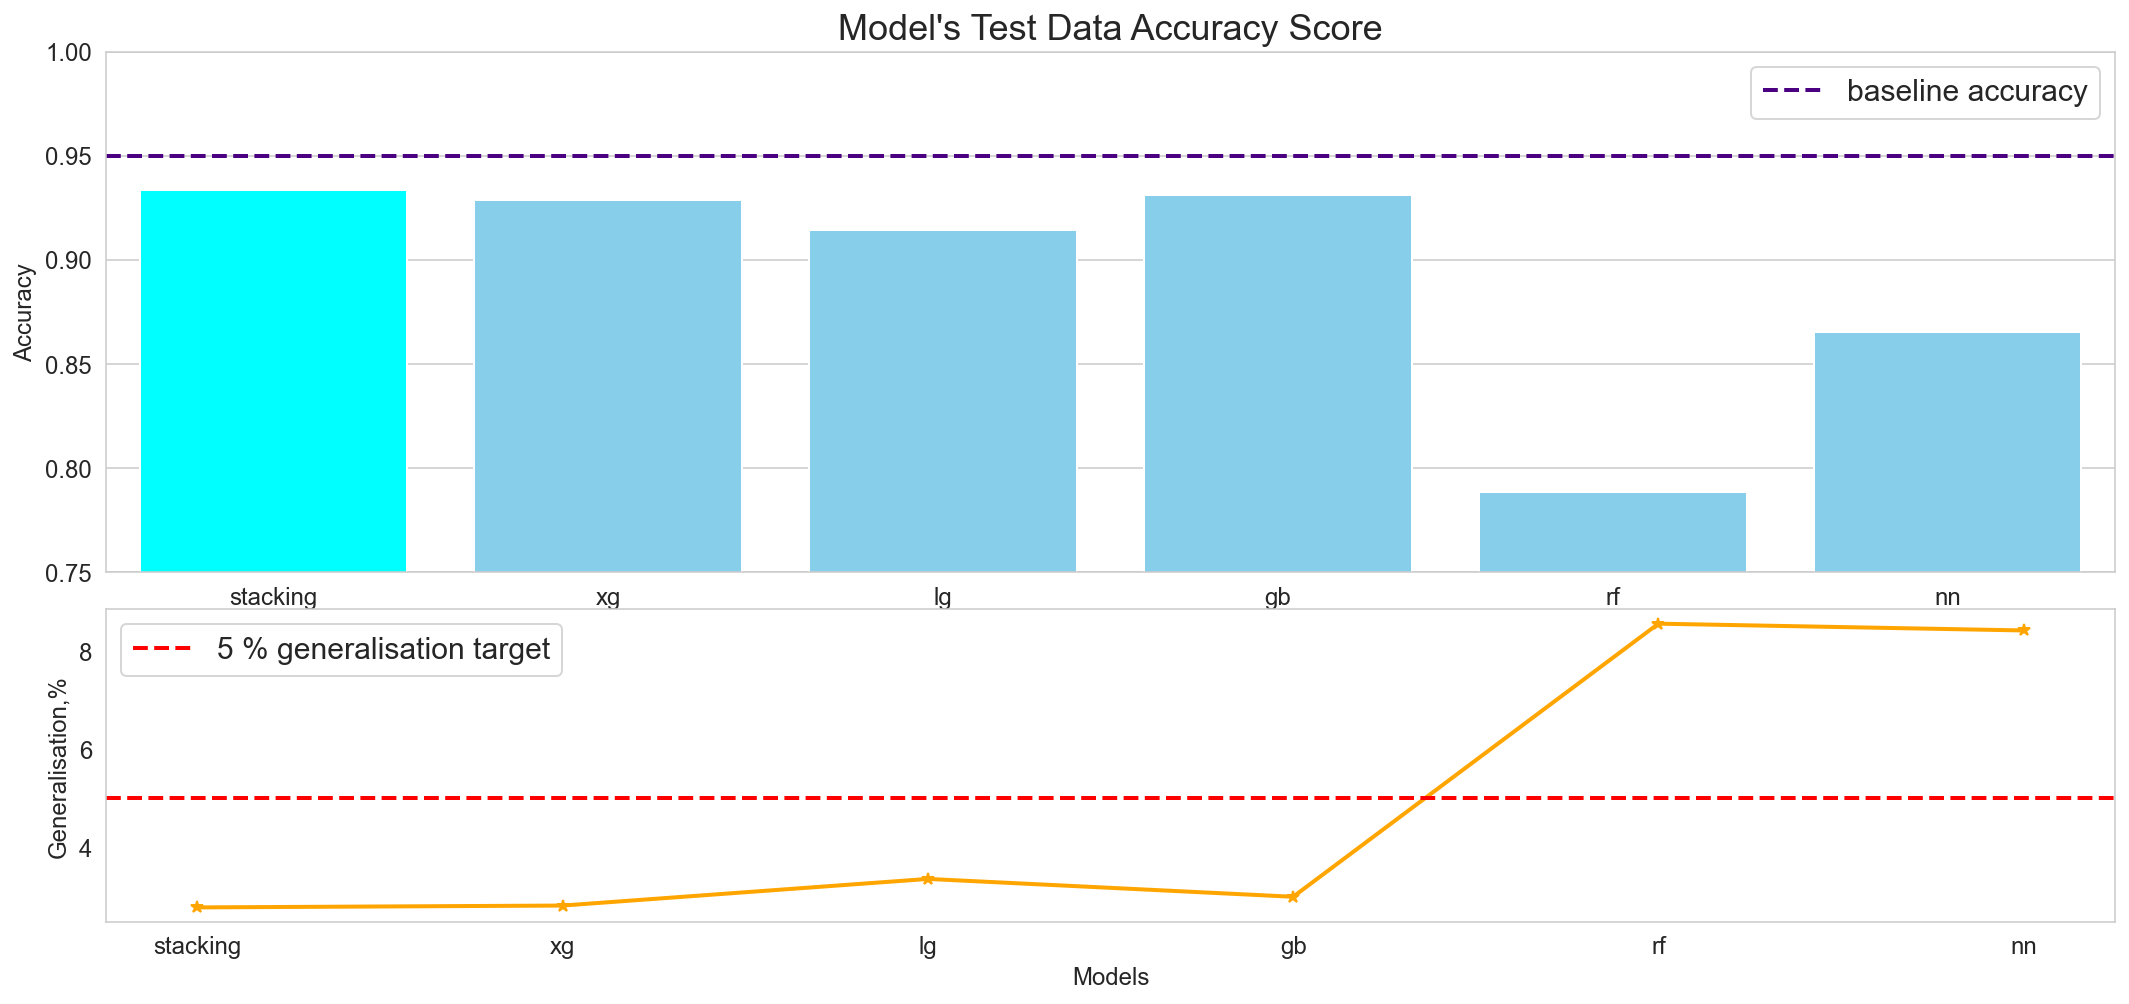

In [16]:
fig,ax = plt.subplots(nrows=2,figsize=(18,8),gridspec_kw={'height_ratios': [5, 3]})
clrs = ['skyblue' if (x in ls) else 'cyan' for x in eval_df['model']]
g = sns.barplot(x = 'model', y = 'accuracy', data=eval_df, palette=clrs,saturation=1,ax=ax[0])
ax[0].set_title('Model\'s Test Data Accuracy Score',fontsize=18)
ax[0].axhline(y=0.95, linestyle='--',color='indigo',label='baseline accuracy',linewidth=2)
ax[0].set_ylim(0.75,1)
ax[0].set_ylabel('Accuracy',fontsize=12)
#ax[0].get_xaxis().set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].legend(fontsize=15,loc='upper right')

ax[1].plot(eval_df['model'],eval_df['generalisation'],color='orange',marker='*', linewidth=2)
ax[1].set_ylabel('Generalisation,%',fontsize=12)
ax[1].set_xlabel('Models',fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].axhline(y=5, linestyle='--',color='red',label='5 % generalisation target',linewidth=2)
ax[1].legend(fontsize=15,loc='upper left')
plt.subplots_adjust(hspace=0.09)
plt.grid()

The plot shows that the accuracy score for `stacking`,`XGBoost`,`LGBoost`,`GradientBoost` are very close but unfortunately cannot beat the baseline accuracy of 95% (the negative class is 95% of everall data). 

However, we decided to accept this result as their defferent with baseline accuracy scpre is less than 3% (except Randomforrest and Neural Network).
On top of that, the generalisation of `stacking`,`XGBoost`,`LGBoost`,`GradientBoost` are all below our limit of 5%  

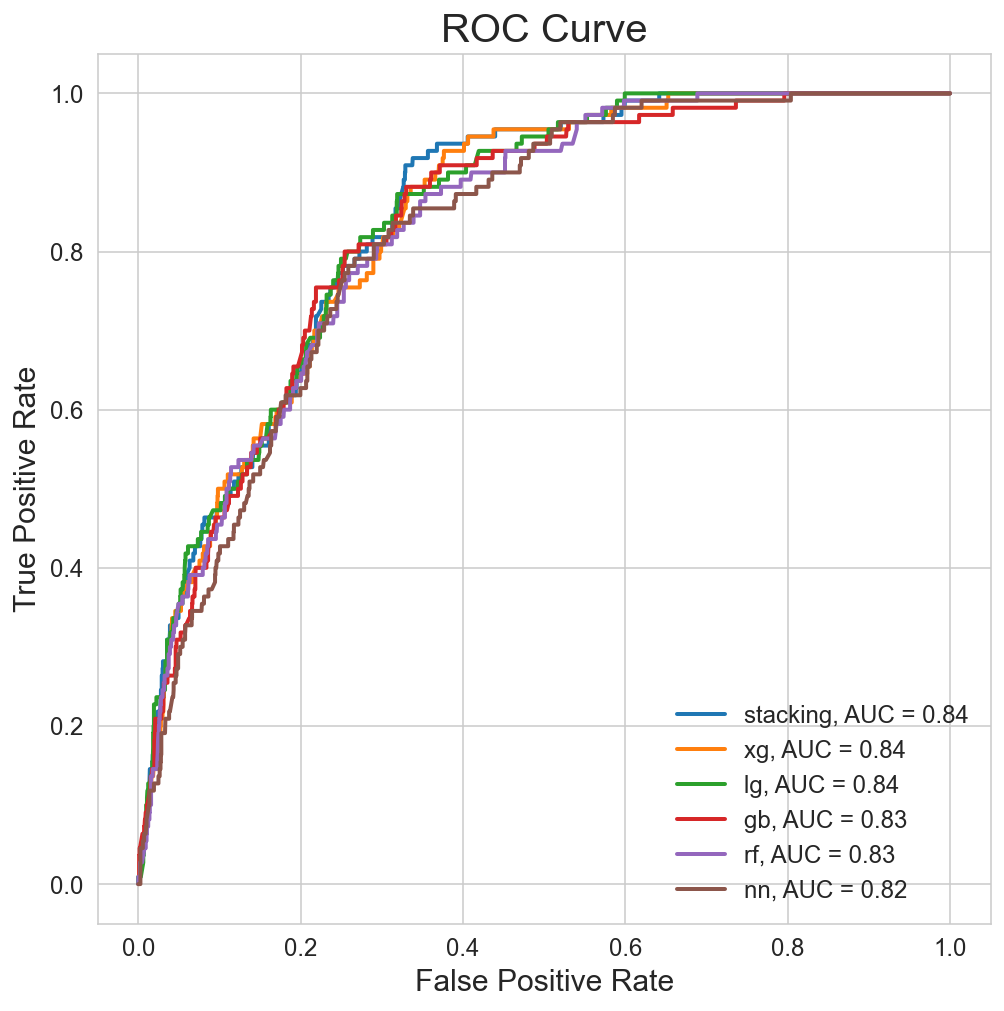

In [17]:
#Plot the ROC curve for the models

fig,ax = plt.subplots(figsize=(8,8))
plt.style.use('seaborn')
for model in eval_df['model']:
  auc = round(eval_df[eval_df['model']==model]['auc score'].values[0],2)
  plt.plot(eval_df[eval_df['model']==model]['fpr'].values[0],eval_df[eval_df['model']==model]['tpr'].values[0], label = f'{model}, AUC = {auc}',linewidth=2)

plt.title('ROC Curve',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)
#ax.set(facecolor = "white")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)
#plt.plot([0, 1], [0, 1], 'g-')
plt.legend(fontsize=12,loc='lower right')

From the `ROC` plot, we could not know which model is significantly better than the others. But all of them are generally having good `AUC` of >0.8.

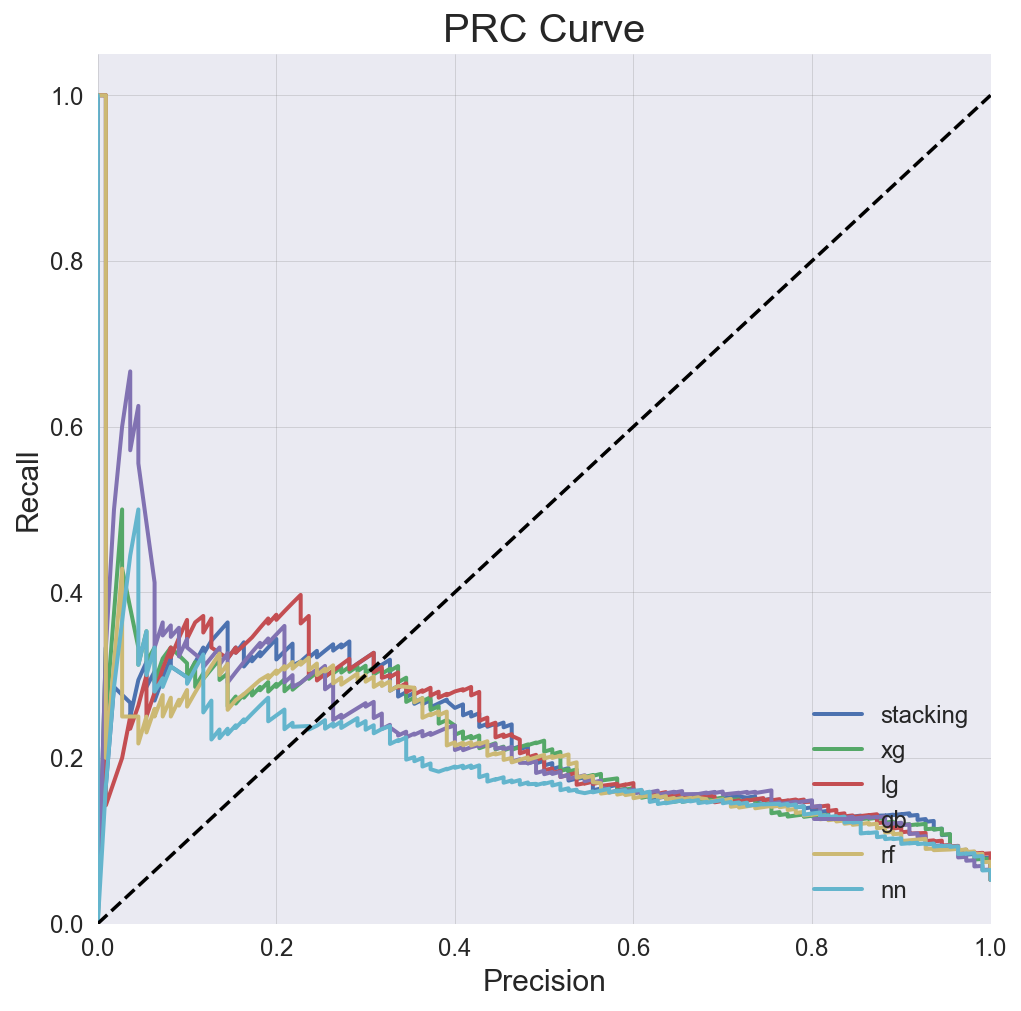

In [18]:
fig,ax = plt.subplots(figsize=(8,8))
plt.style.use('seaborn')
for model in eval_df['model']:
  plt.plot(eval_df[eval_df['model']==model]['Recall'].values[0],eval_df[eval_df['model']==model]['Precision'].values[0], label = f'{model}',linewidth=2)

plt.title('PRC Curve',fontsize=20)
ax.set_xlabel('Precision',fontsize=15)
ax.set_ylabel('Recall',fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=12)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=12,loc='lower right')

According to the plots and score, the `Stacking` model is selected as our best model: 

| Model | Test accuracy score | Generalisation | ROC-AUC 
| --- | --- | --- | --- |
| stacking | 0.933 | 2.77 | 0.844 | 
| XGBoost | 0.928 | 2.80 | 0.838 |
| LGB | 0.914 | 3.35 | 0.841 |
| Gradient Boost | 0.931 | 2.99 | 0.833 |

The metrics of stacking is sligthly outperform the other model. But here we come to a question, which is the benefit to cost ratio fo spend the engineering resources to stack the models to improve the accuracy by less than 2%? 
If we have limited time and man power  , we could have just select the `Gradient Boost` model to proceed to our analysis. Another way is pend the resources to revise our feature engineering steps in order to improve our model.


---

But for the `recall-precision` plot, we can notice that the models are having poor recall (on positive class). 
```
Recall  = ratio of true positive to (true positive+false negative)
F1 Score = the harmonic mean of precision and recall
```
In our case, we need a better recall score to make sure we can minimize the chance of predicting a true positive mosquito as negative . The false classification of positive case to negative class will make the study on the effect of spraying less accurate within a time period.
Hence, we will investigate which threshold is ideal in this study by sacrifice small portion of accuracy and f1-score(maybe)

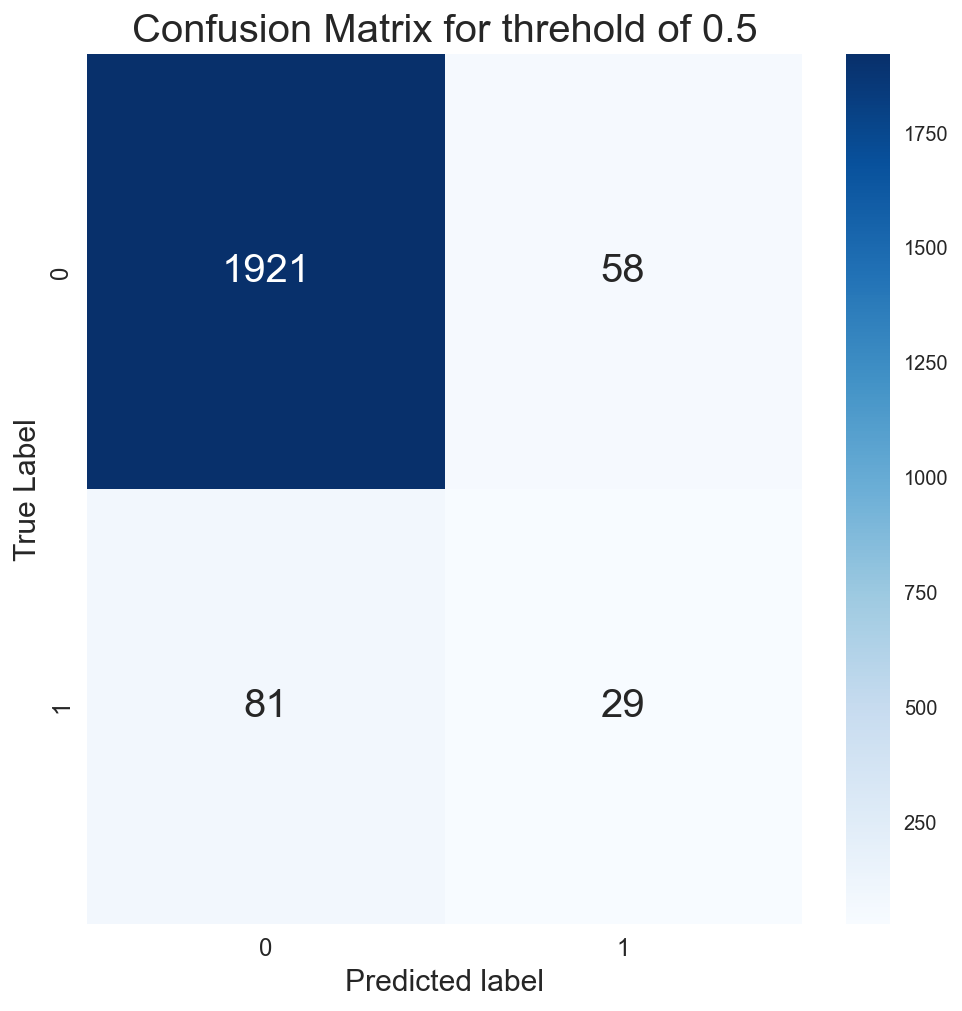

Recall:  0.26
F1 Score:  0.29


In [19]:
# Evaluate for the test data with threshold = 0.5
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
recall = tp/(tp+fn)
f1_score = 2*tp/(2*tp+fp+fn)


fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',cmap = 'Blues',annot_kws={"fontsize":20})
plt.title('Confusion Matrix for threhold of 0.5',fontsize=20)
ax.set_xlabel('Predicted label',fontsize=15)
ax.set_ylabel('True Label',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()
print('Recall: ',round(recall,2))
print('F1 Score: ',round(f1_score,2))


The recall and F1 score are not ideal, it has too less true positive sample.

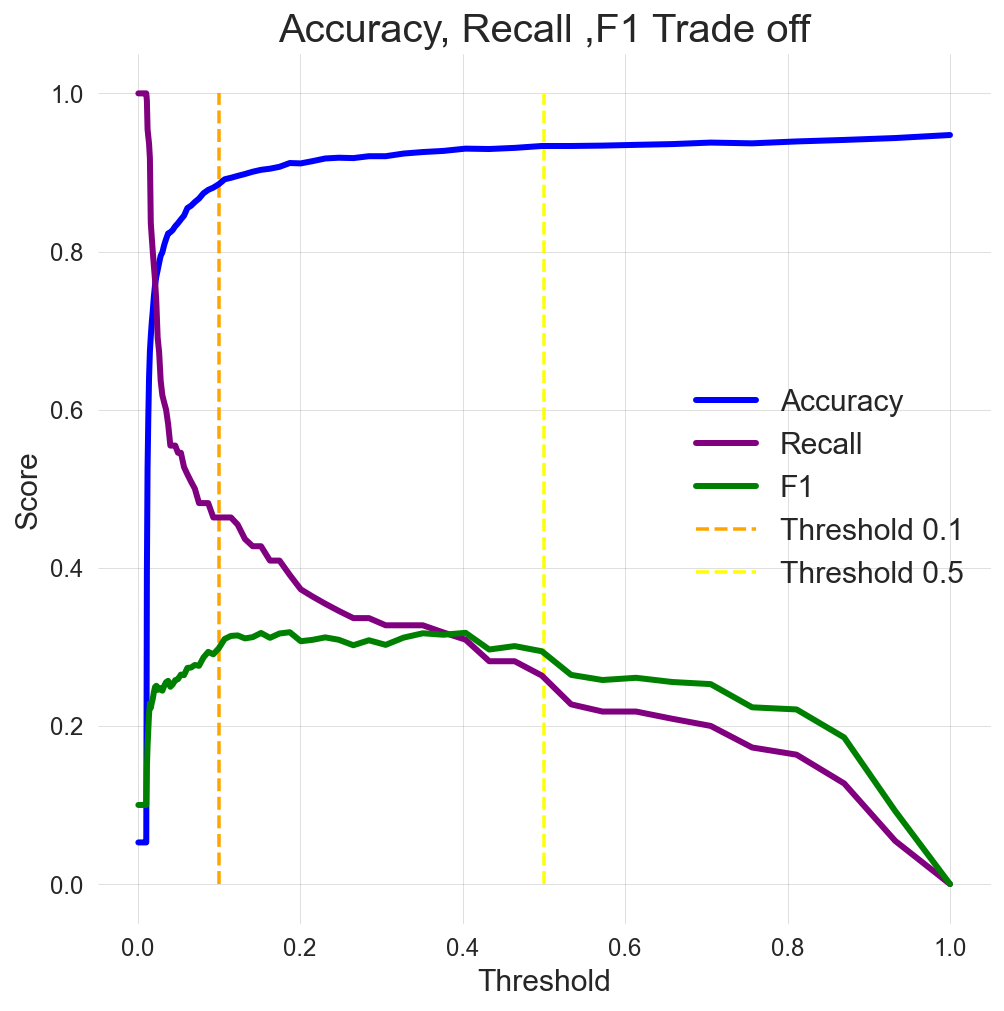

In [20]:
# now we will try to find the best threshold for the model
# we will use the F1 score as the evaluation metric
from turtle import color


acc_ls = []
f1_ls = []
recall_ls = []

for i in np.logspace(-3,0,100):
    y_pred = np.where(y_pred_prob > i, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    f1_score = 2*tp/(2*tp+fp+fn)
    recall = tp/(tp+fn)
    acc_ls.append(accuracy)
    recall_ls.append(recall)
    f1_ls.append(f1_score)

fig,ax = plt.subplots(figsize=(8,8))

ax.plot(np.logspace(-3,0,100),acc_ls, label = 'Accuracy',linewidth=3,color='blue')
ax.plot(np.logspace(-3,0,100),recall_ls, label = 'Recall',linewidth=3,color='purple')
ax.plot(np.logspace(-3,0,100),f1_ls, label = 'F1',linewidth=3,color='green')
ax.set_title('Accuracy, Recall ,F1 Trade off',fontsize=20)
ax.set_xlabel('Threshold',fontsize=15)
ax.set_ylabel('Score',fontsize=15)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.vlines(0.1,0,1,linestyles='dashed',label='Threshold 0.1',colors='orange')
ax.vlines(0.5,0,1,linestyles='dashed',label='Threshold 0.5',colors='yellow')
ax.set(facecolor = "white")
plt.legend(fontsize = 15,loc='center right')
plt.show()

From this plot, it can be noticed that by shifting our threshold from 0.5 to 0.1, we got better recall and F1 score by just sacrifice small amount of accuracy.
Lets evaluate the model with threshold of 0.1.

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1979
           1       0.22      0.46      0.30       110

    accuracy                           0.89      2089
   macro avg       0.59      0.69      0.62      2089
weighted avg       0.93      0.89      0.90      2089



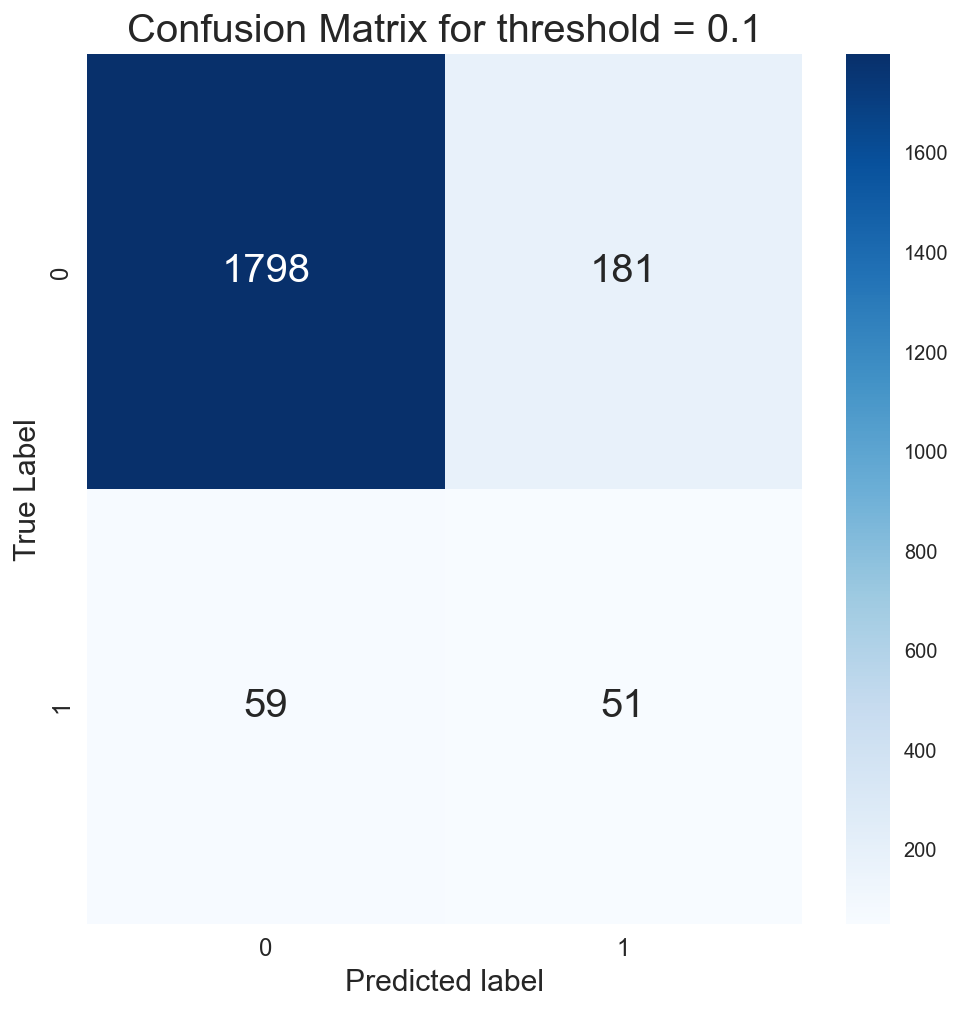

In [21]:
y_pred = np.where(y_pred_prob > 0.10, 1, 0)
print(classification_report(y_test, y_pred))

fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',cmap = 'Blues',annot_kws={"fontsize":20})
plt.title('Confusion Matrix for threshold = 0.1',fontsize=20)
ax.set_xlabel('Predicted label',fontsize=15)
ax.set_ylabel('True Label',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Results:

| mertics | threshold = 0.5 | threshold = 0.1 | %change
| --- | --- | --- | --- |
| Accuracy | 0.93 | 0.89 | 4.3% |
| F1 score | 0.28 | 0.30 | 7% |
| Recall | 0.26 |0.46 | 77% | 

From the result, the change of threshold of stacking model from 0.5 to 0.1 able to improve the recall score by 77% by just scarifice 4% of model accuracy .
Hence, the model is so far in its best setting to predict the present of WNV on the test data year.

---

### Next , the lift curves are plotted in order to  generate more insight.

In [22]:
# Function that plots a Lift Curve using the real label values of a dataset and the probability predictions of a Machine Learning Algorithm/model
# y_val: real labels of the data
# y_pred: probability predictions for such data
# step: how big we want the steps in the percentiles to be

def get_lift(y_val, y_pred_prob, step=0.0101):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred_prob
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
    return x_val, y_v

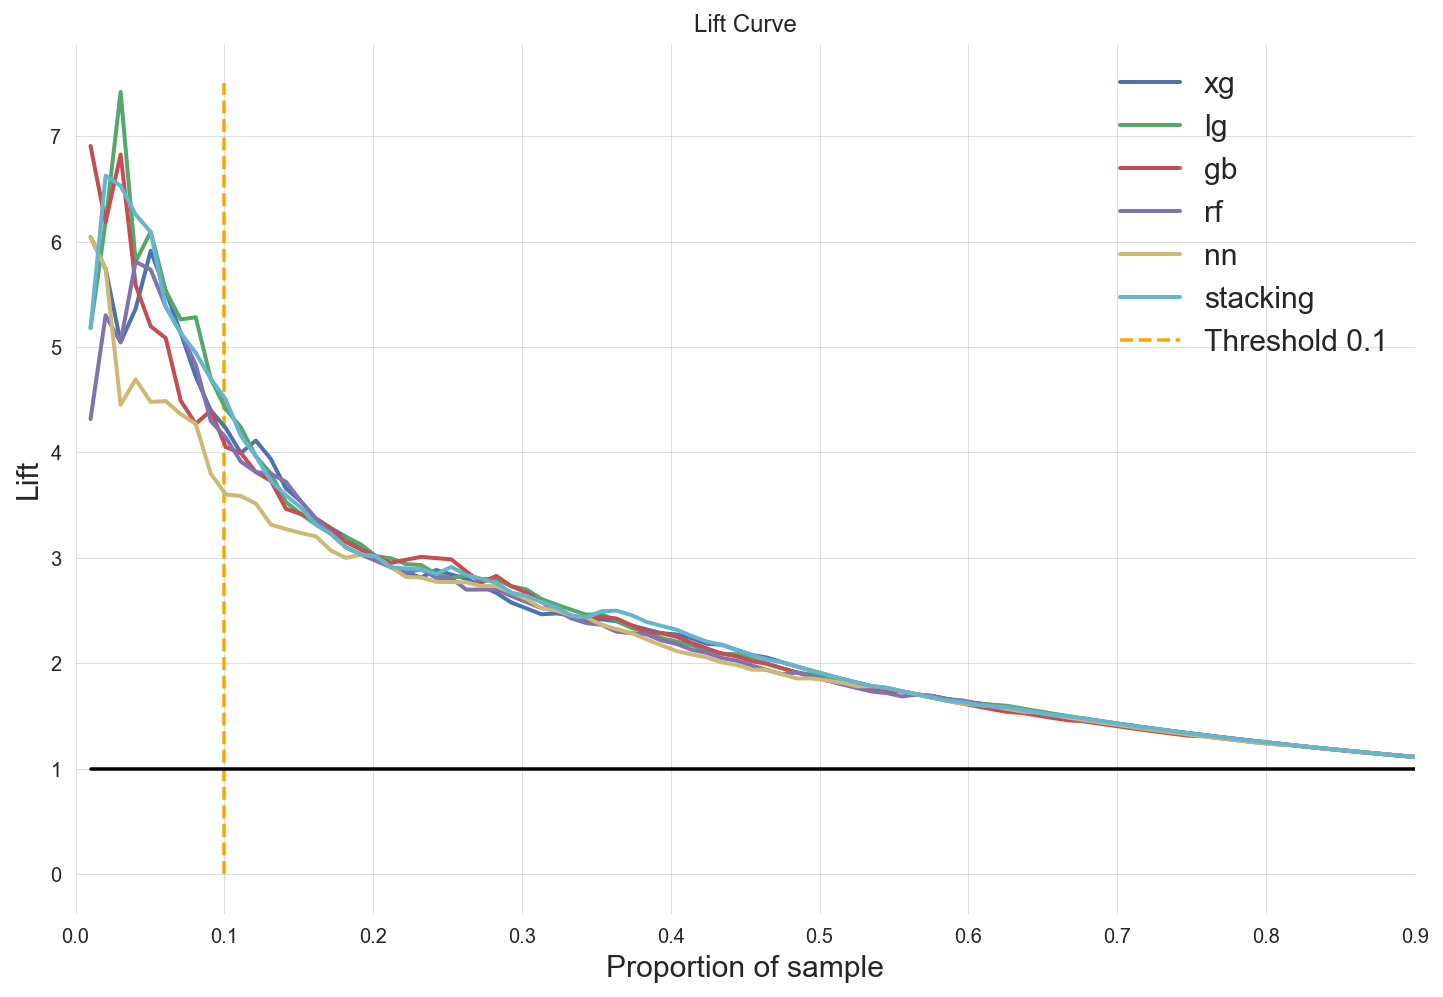

In [23]:
#Plot the figure
ls = ['xg', 'lg', 'gb', 'rf', 'nn']
lift = {}
for i in range(len(ls)):
    x_val, y_v = get_lift(y_test, X_test[:,i])
    lift[ls[i]] = x_val, y_v

x_val,y_v = get_lift(y_test, y_pred_prob)
lift['stacking'] = x_val, y_v
lift_df = pd.DataFrame(lift,index=['x','lift']).T
lift_df['model'] = lift_df.index

fig,ax = plt.subplots(figsize=(12,8))
plt.style.use('seaborn')
for model in lift_df['model']:
  plt.plot(lift_df[lift_df['model']==model]['x'].values[0],lift_df[lift_df['model']==model]['lift'].values[0], label = f'{model}',linewidth=2,markersize=2)

#plt.plot(lift_df['x'].values[0], lift_df[lift_df['model']=='stacking']['lift'].values[0], marker='', color='green', linewidth=2))
#plt.text(0, 7.5, 'Highest Lift = 6-7', horizontalalignment='left', size='large')
plt.title('Lift Curve',fontsize=20)
ax.plot(x_val, np.ones(len(x_val)), 'k-')
ax.set_xlabel('Proportion of sample',fontsize=15)
ax.set_ylabel('Lift',fontsize=15)
ax.set_xlim(0,0.9)
ax.set(facecolor = "white")
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.vlines(0.1,0,7.5,linestyles='dashed',label='Threshold 0.1',colors='orange')
plt.legend(fontsize = 15,loc='upper right')
plt.title('Lift Curve')
plt.show()


Interpretation:

Except neural network, all models seems to have similar lift curve, where topped at around 6 to 7 .
So, by taking the region where all the models starting to converge, which is at around top 10% of sample, where the lift is 4. Then we can make a assumption which is 
```
By taking sample the locations that have top 10 % cluster of present of WNV, we have 4 times higher chance to capture the present of virus compare to randomly sampling over the state
```  

--- 
### Kaggle Competion Submission

In [24]:
#for Kaggle competition submission

with open('./datasets/id.pickle', 'rb') as f:
    id = pickle.load(f)
with open('./datasets/test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

def prediction(x):

    xg_test= xg.predict(x).reshape(-1, 1)
    lg_test= lg.predict(x).reshape(-1, 1)
    gb_test= gb.predict(x).reshape(-1, 1)
    rf_test= rf.predict(x).reshape(-1, 1)
    nn_test= nn.predict(x).reshape(-1, 1)

    X_test = np.concatenate(( xg_test, lg_test, gb_test), axis=1)
    y_pred = meta.predict_proba(X_test)[:,1]
    #y_pred = np.mean(X_test, axis=1)

    return y_pred

y_sub = prediction(test_data)

df_sub = pd.DataFrame({'Id': id.values.squeeze(), 'WnvPresent': y_sub})
df_sub = df_sub.sort_values(by='Id')
df_sub.set_index('Id', inplace=True)
df_sub.to_csv('./datasets/submission.csv')


228/228 [==============================] - 1s 5ms/step


---

## 4.3 Result and Recommendation

The simulation of present of virus in year 2008,2010,2012,2014 will be plotted by using our prediction model


In [25]:
#Import the original test dataset and concatenate it with the predictions (with threshold 0.1)
mapdata = np.loadtxt("./assets/input/mapdata_copyright_openstreetmap_contributors.txt")
train = pd.read_csv('./assets/input//train.csv')
spray = pd.read_csv('./assets/input/spray.csv')
df_weather = pd.read_csv('./assets/input/weather.csv')

df_test = pd.read_csv('./assets/input/test.csv', parse_dates=[1], infer_datetime_format=True)
y_pred_test = np.where(y_sub > 0.1, 1, 0)
test_result = pd.concat([df_test, pd.DataFrame(y_pred_test, columns=['WnvPresent'])], axis=1)
test_result.head()

Id       Date                                            Address  \
0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   WnvPresent  
0           0  
1           0  
2           0  
3           0  
4           0

In [26]:
# Combine the test and train data 
overall = pd.concat([train, test_result], axis=0, sort='Date')
overall.drop(columns=['Address', 'AddressNumberAndStreet', 'NumMosquitos', 'AddressAccuracy','Block','Id','Street','Species','Trap'], inplace=True)
print(overall.shape)
print(overall.columns)

(126799, 4)
Index(['Date', 'Latitude', 'Longitude', 'WnvPresent'], dtype='object')


In [27]:
#preprocessing of dataset
overall['Date'] = pd.to_datetime(overall['Date'])
overall['Year'] = overall['Date'].dt.year
overall['Month'] = overall['Date'].dt.month
overall['Year_Month'] = overall['Year'].astype(str)+'_'+ overall['Month'].astype(str)
overall['Day'] = overall['Date'].dt.day
overall.head()

Date   Latitude  Longitude  WnvPresent  Year  Month Year_Month  Day
0 2007-05-29  41.954690 -87.800991           0  2007      5     2007_5   29
1 2007-05-29  41.954690 -87.800991           0  2007      5     2007_5   29
2 2007-05-29  41.994991 -87.769279           0  2007      5     2007_5   29
3 2007-05-29  41.974089 -87.824812           0  2007      5     2007_5   29
4 2007-05-29  41.974089 -87.824812           0  2007      5     2007_5   29

In [28]:
#SPray dataset setup
spray = spray[(spray['Latitude'] <= 42.02)&(spray['Longitude'] <= -87.5316)] #filter the outlier
spray['Date'] = pd.to_datetime(spray['Date']) # convert the Date column to datetime
spray['Year'] = spray['Date'].dt.year # create a new column for year
df_spray = spray.groupby(['Year','Latitude','Longitude']).max().reset_index() 
df_spray.head()

Year   Latitude  Longitude       Date        Time
0  2011  41.968435 -87.802447 2011-09-07  8:45:22 PM
1  2011  41.968442 -87.801713 2011-09-07  8:45:12 PM
2  2011  41.968538 -87.799545 2011-09-07  8:40:02 PM
3  2011  41.968553 -87.788695 2011-09-07  7:58:12 PM
4  2011  41.968557 -87.789108 2011-09-07  7:58:22 PM

In [29]:
# Plotting set-up

# plt colour map colour setting to see the map clearler
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]  #define map aspect ratio 
lon_lat_box = (overall['Longitude'].min()-0.01, overall['Longitude'].max()+0.01, overall['Latitude'].min()-0.01, overall['Latitude'].max()+0.01) #define map size

# grid of the map
xv,yv = np.meshgrid(np.linspace(lon_lat_box[0], lon_lat_box[1], 100), np.linspace(lon_lat_box[2], lon_lat_box[3], 100))  #mesggrid is a function that returns coordinate matrices from coordinate vectors with 100 steps in this case
gridpoints = np.array([xv.ravel(),yv.ravel()]).T # ravel() is a function that flattens the array, and T is a function that transposes the array fo that it is now a (2 x n) array before get the coordinates of the grid points from kernal density

In [30]:
# Wvn plot
from sklearn.neighbors import KernelDensity

def wvn_countour_plot(df, years=[2007,2008,2009,2010,2011,2012,2013,2014],df_spray=df_spray):
  fig, ax = plt.subplots(figsize=(25, 40), sharex=True, sharey=True)


  for i, year in enumerate(years,1):
    
    df_year = df[overall['Year']==year]
    X = df_year[df_year['WnvPresent'] == 1][['Longitude', 'Latitude']].values # get the coordinates of the traps that caught mosquitos, and put them in a numpy array of shape (n,2)
  
    # Inititate the kernel density from sklearn
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)  #2D kernal density fit
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))  #z vector, the third axis of this plot is the density of mosquitos in each grid point, then reshpae into the original plot shape
  
    ax = plt.subplot(len(years), 4, i)

    plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect
          )
    plt.imshow(zv, 
           origin='lower', 
           cmap=alpha_cm, 
           extent=lon_lat_box, 
           aspect=aspect
           )

    spr = df_spray[df_spray['Year']==year][['Longitude', 'Latitude']].values
    plt.scatter(spr[:,0], spr[:,1], marker='o', color='yellow', s=2)
  

    locations = df_year[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], marker='x',s=25)
  
    plt.title('Present of MVN Countor plot in Year: {} \n Blue represent trap \n Yellow represent sprayed area'.format(year),size=15) 
    ax.set_yticklabels([])

  plt.subplots_adjust(hspace=0.5)
  plt.tight_layout()  
  plt.show()

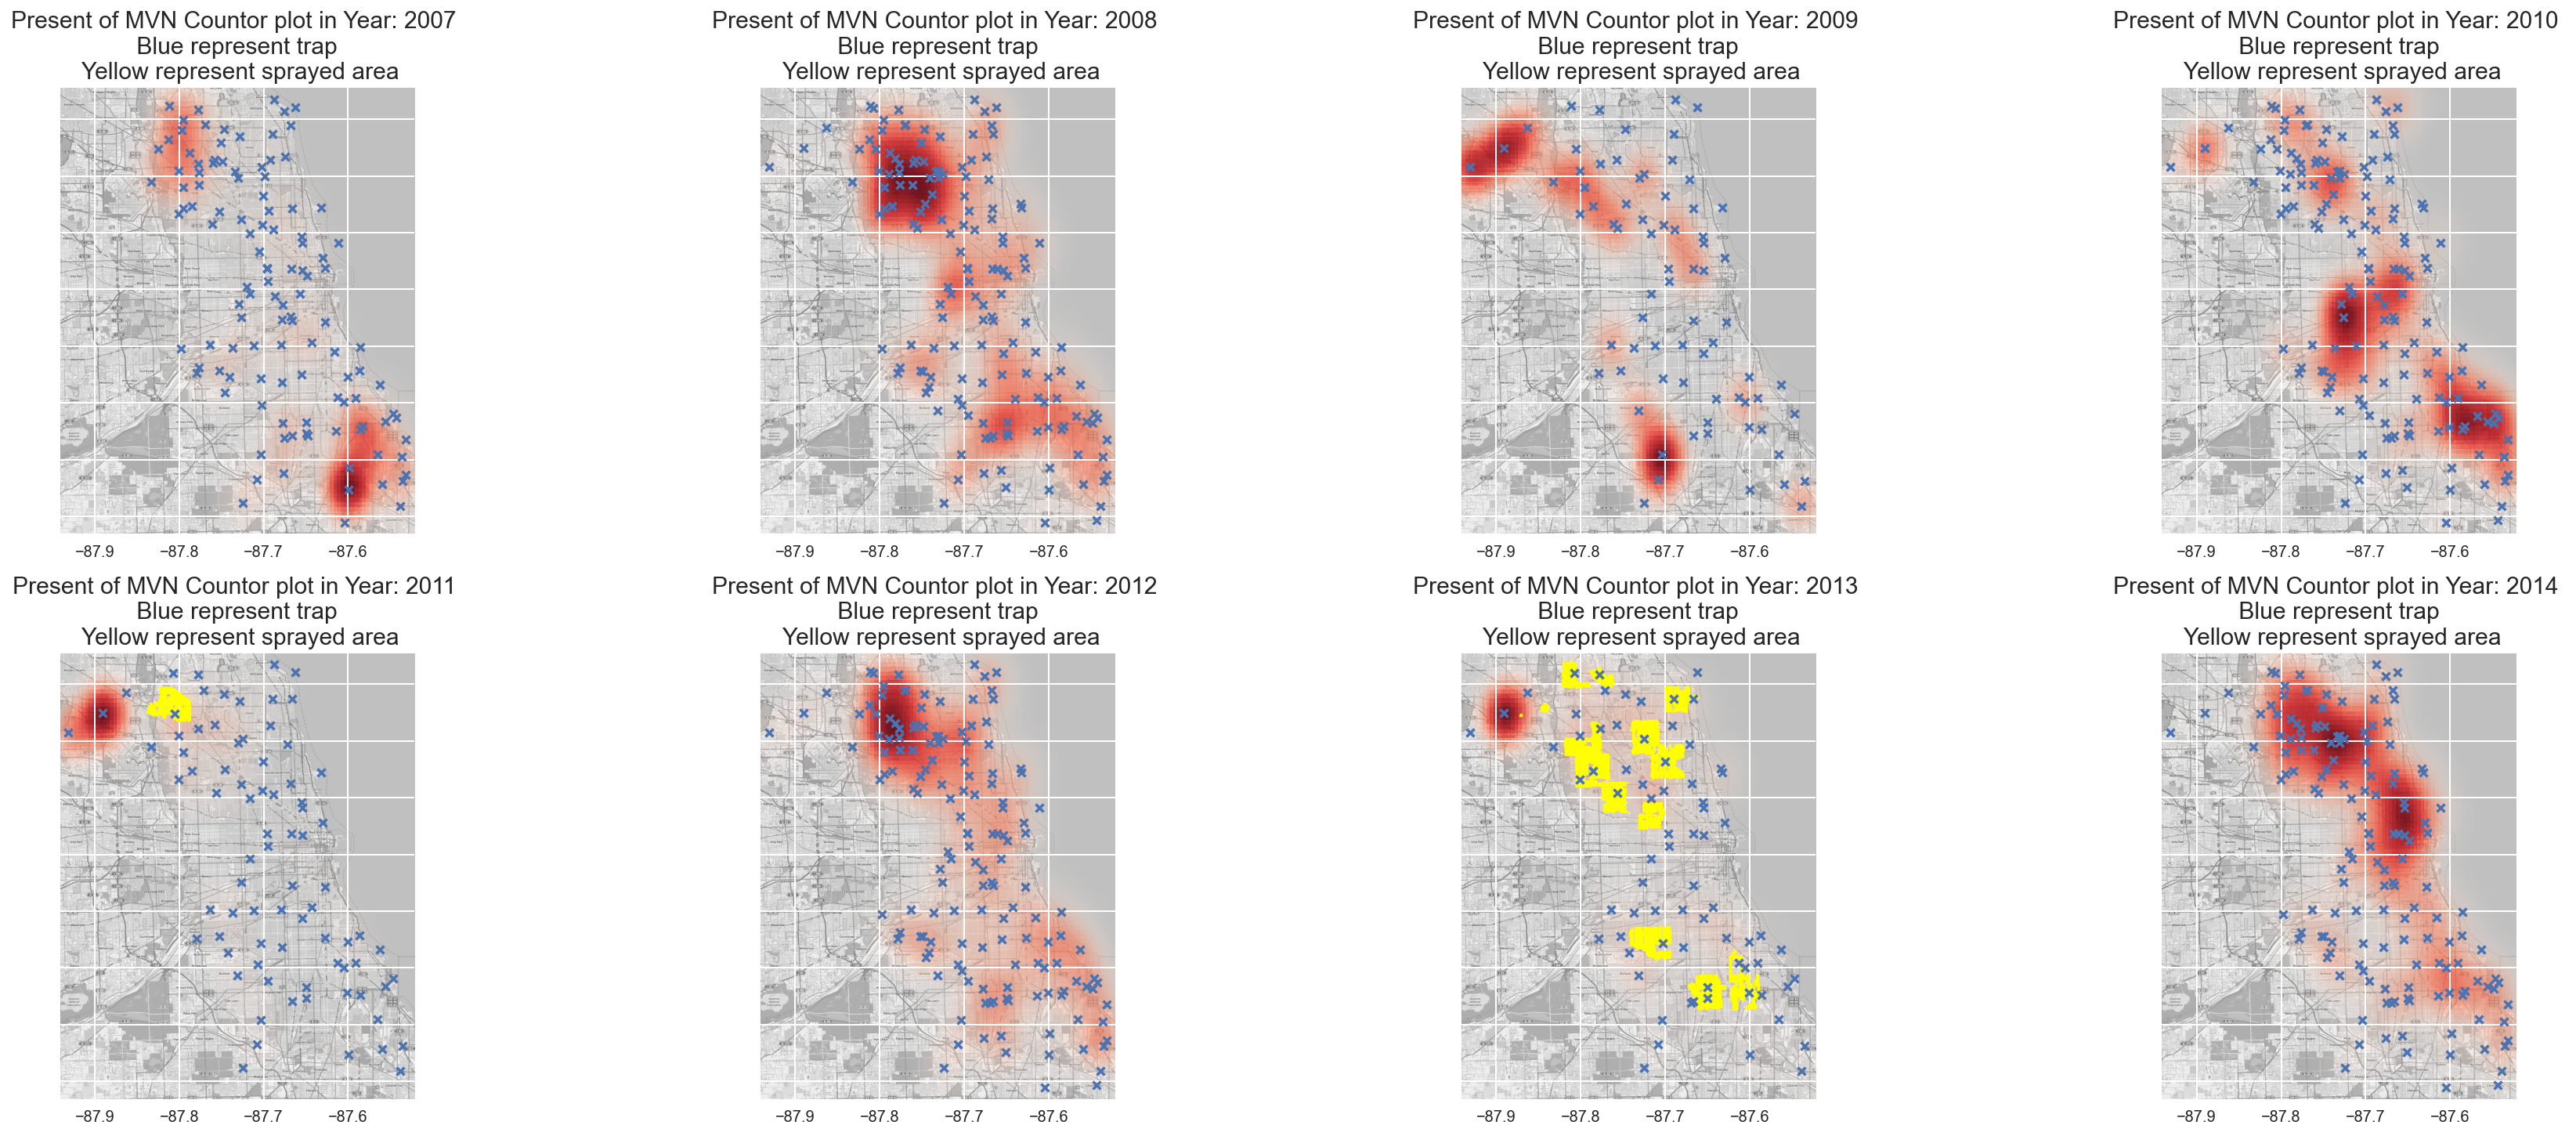

In [31]:
wvn_countour_plot(overall)

#### The locations are the high predictor for the present of virus, but it does not show signioficant changing trend along the years

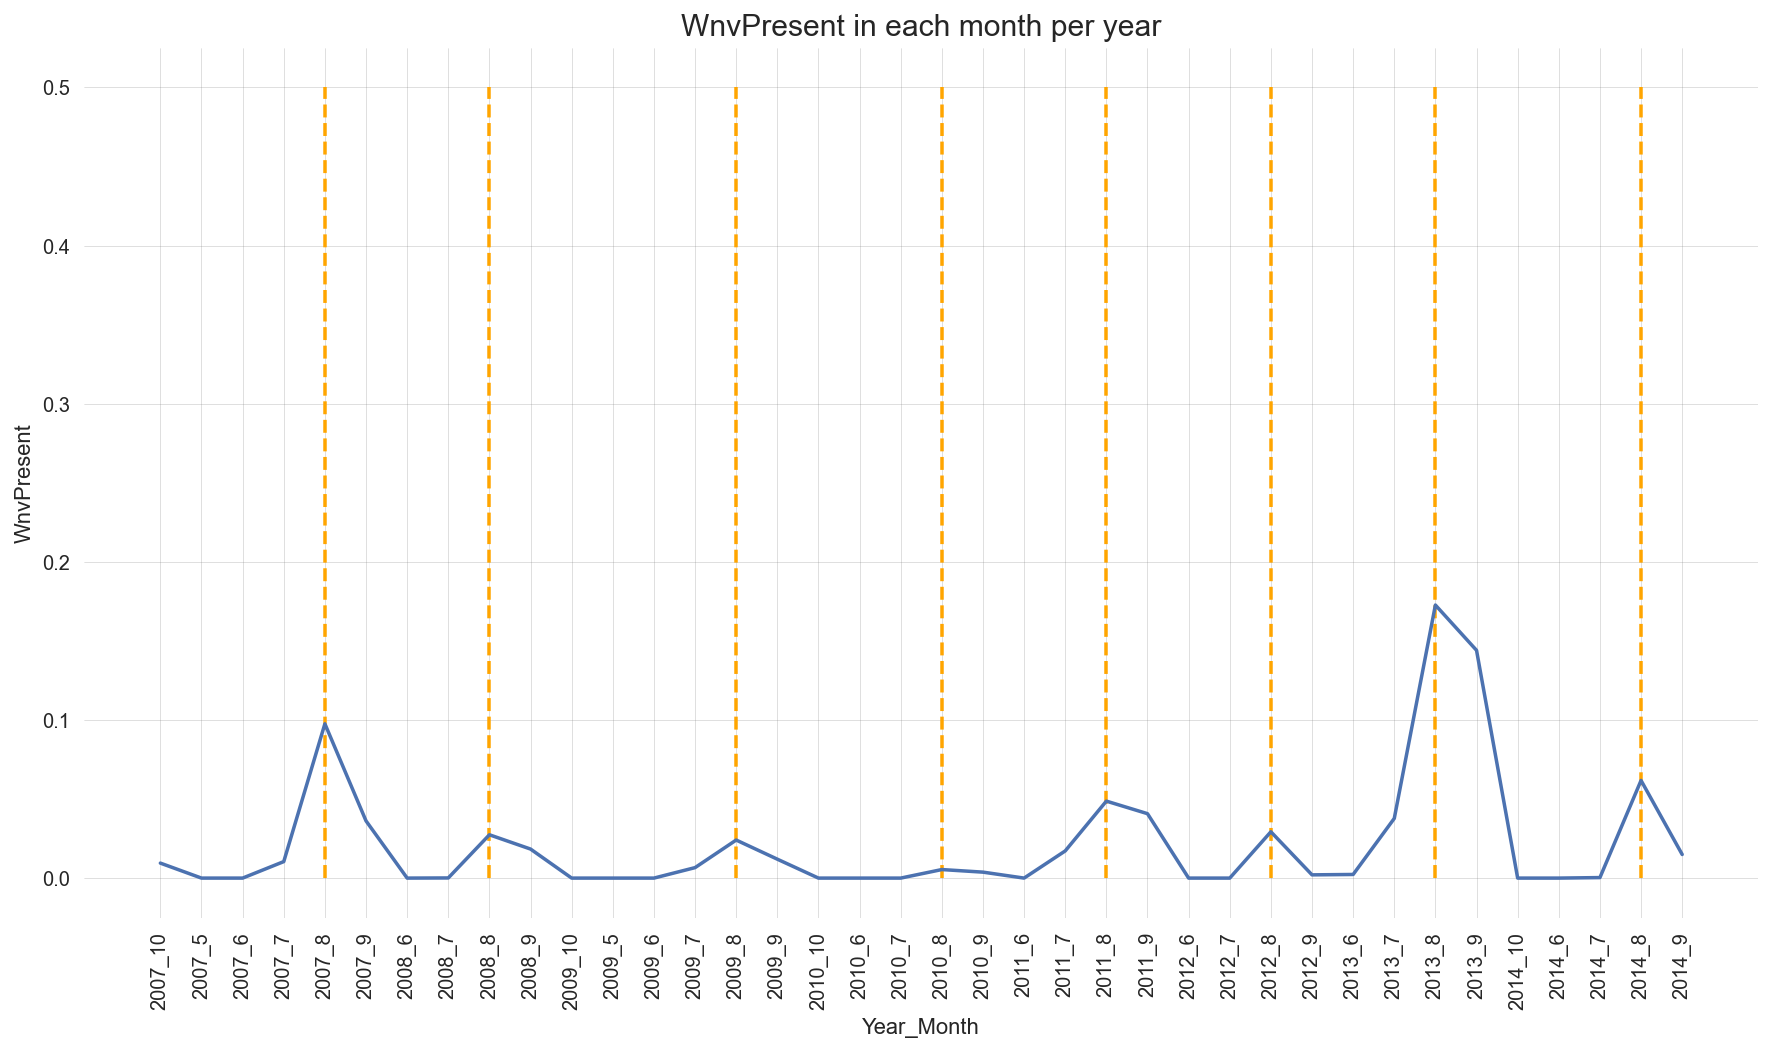

In [32]:
overall_pm = overall.groupby(['Year_Month']).agg({'WnvPresent':np.mean}).reset_index()

fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(overall_pm['Year_Month'],overall_pm['WnvPresent'], ax=ax)
plt.xticks(rotation=90)
plt.title('WnvPresent in each month per year',size=15)
ax.set(facecolor = "white")
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.vlines(['2007_8','2008_8','2009_8','2010_8','2011_8','2012_8','2013_8','2014_8'],0,0.5,linestyles='dashed',label='Threshold 0.1',colors='orange')

#### We can see the high spike are always on month of August, so we need to figure out what are the factor that has correlation with months

#### Since the feature imprtance from modelling in XGBoost tell us the `Sunrise` is one of the strong predictor, the relation of the sunrise and sunset with month will be visualized 

In [33]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['year'] = df_weather['Date'].dt.year
df_weather['month'] = df_weather['Date'].dt.month

df_weather['Sunrise'].replace("-", np.nan, inplace=True)
df_weather['Sunset'].replace('-', np.nan, inplace=True)
df_weather['Sunrise'].fillna(method='ffill', inplace=True)
df_weather['Sunset'].fillna(method='ffill', inplace=True)
df_weather['Sunrise'] = df_weather['Sunrise'].astype(int)
df_weather['Sunset'] = df_weather['Sunset'].astype(int)

df_weather1 = df_weather.groupby(['month'])['month','Sunrise','Sunset'].agg({'Sunrise':np.mean,'Sunset':np.mean}).reset_index()

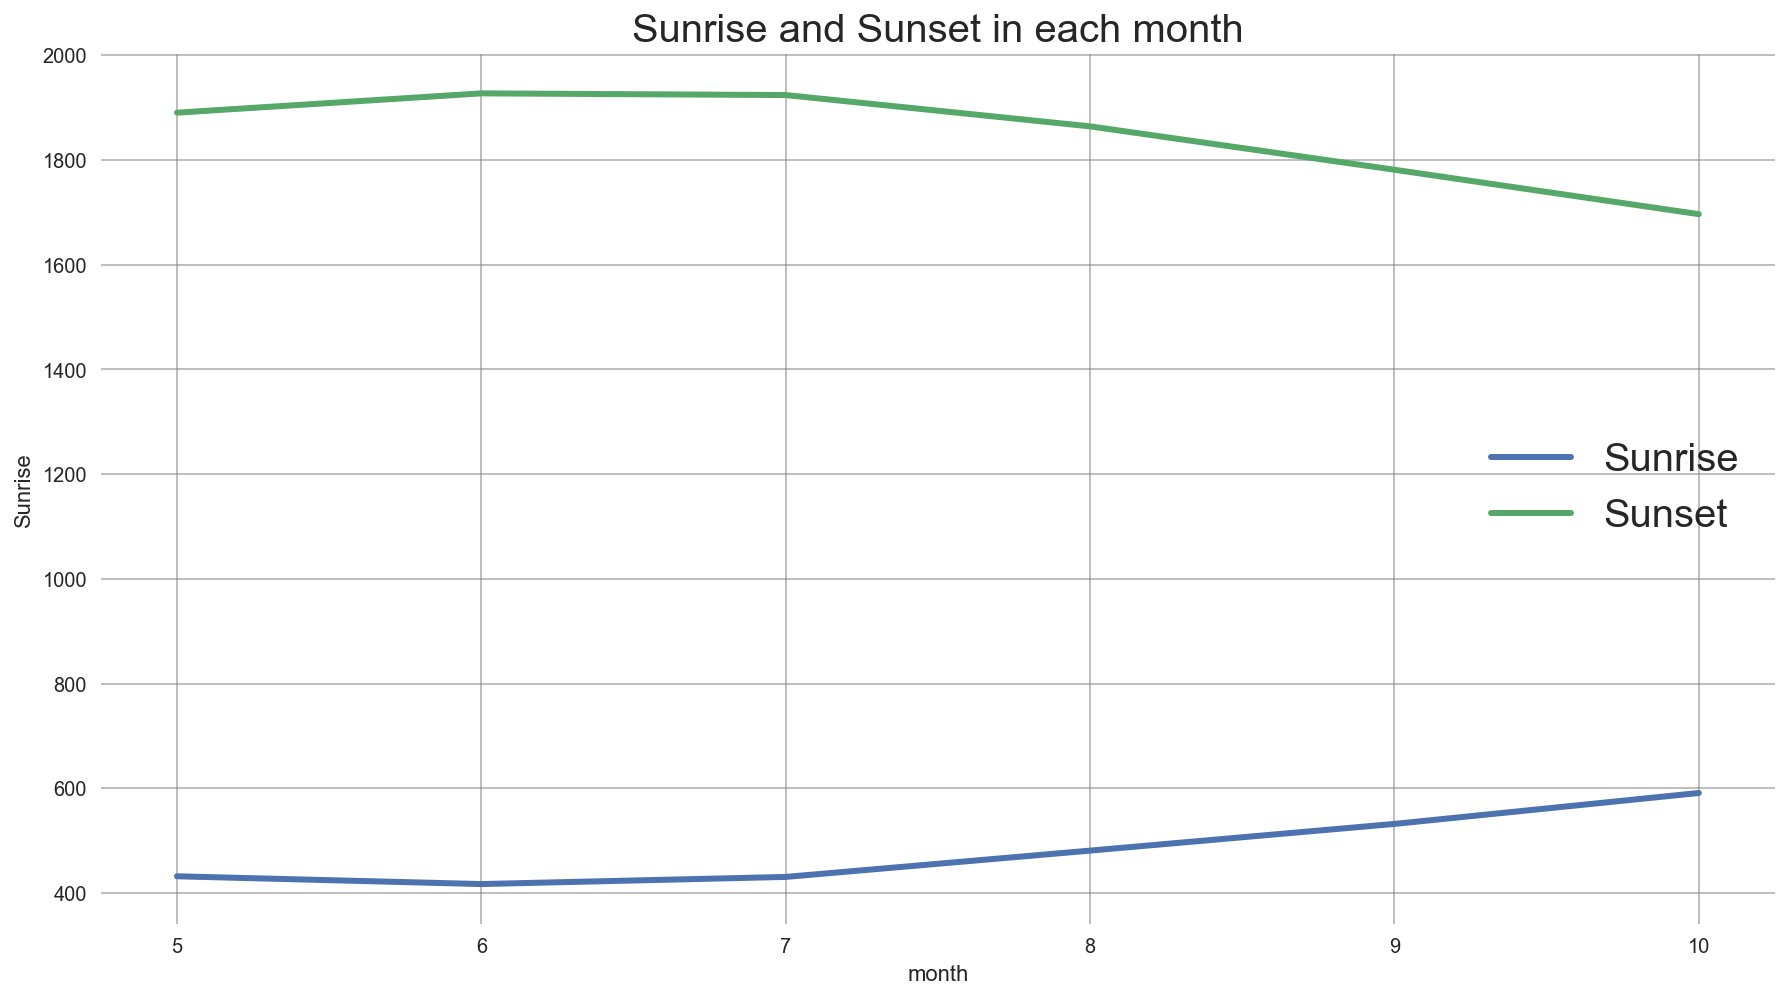

In [34]:
fig,ax = plt.subplots(figsize=(15,8))

sns.lineplot(df_weather1['month'],df_weather1['Sunrise'],label='Sunrise',linewidth=3,ax=ax)
sns.lineplot(df_weather1['month'],df_weather1['Sunset'],label='Sunset',linewidth=3,ax=ax)
plt.title('Sunrise and Sunset in each month',size=20)
plt.legend(fontsize=20)
ax.set(facecolor = "white")
ax.grid(color='grey', linestyle='-', linewidth=1, alpha=0.5)

### The key takeways from the plotting of our result are:

1. The cluster of Wnv present are highly dependent on the location, there are certain location trap always caught mosquitos that have the virus. 
2. There is no clear trend on years and no significatnt effect of spraying from the result.
3. However, the trend by month are very obvious, where the preriod from July to September on each year are the peak of the number of present of Wnv.
4. Furthermore, the daylight of August is not the longerst nor shorter, we will like to make a hypothesis that the effect of transmission of WNV is delayed(the peak of the trasmission would be in June-July)

On top of that, we can relate the weather data from `Part1:EDA` to identify the features that have high correlation with months of year. They are:

- Temperature
- Standard Pressure
- Sunrise and Sunset time (lenght of the day)

Hence, an improved strategies to battle this virus can be optimized by taking all the features mentioned into consideration

---

Using the lift curve plotted in `4.2 Model Evaluation`, we decided to target the top 10% location that have high cluster of virus

In [35]:
overall_loca   = overall.groupby(['Latitude','Longitude']).agg({'WnvPresent':np.mean}).reset_index()
overall_loca1 = overall_loca[overall_loca['WnvPresent']>=(overall_loca['WnvPresent'].quantile(0.9))]
print(overall_loca.shape,overall_loca1.shape)


(151, 3) (16, 3)


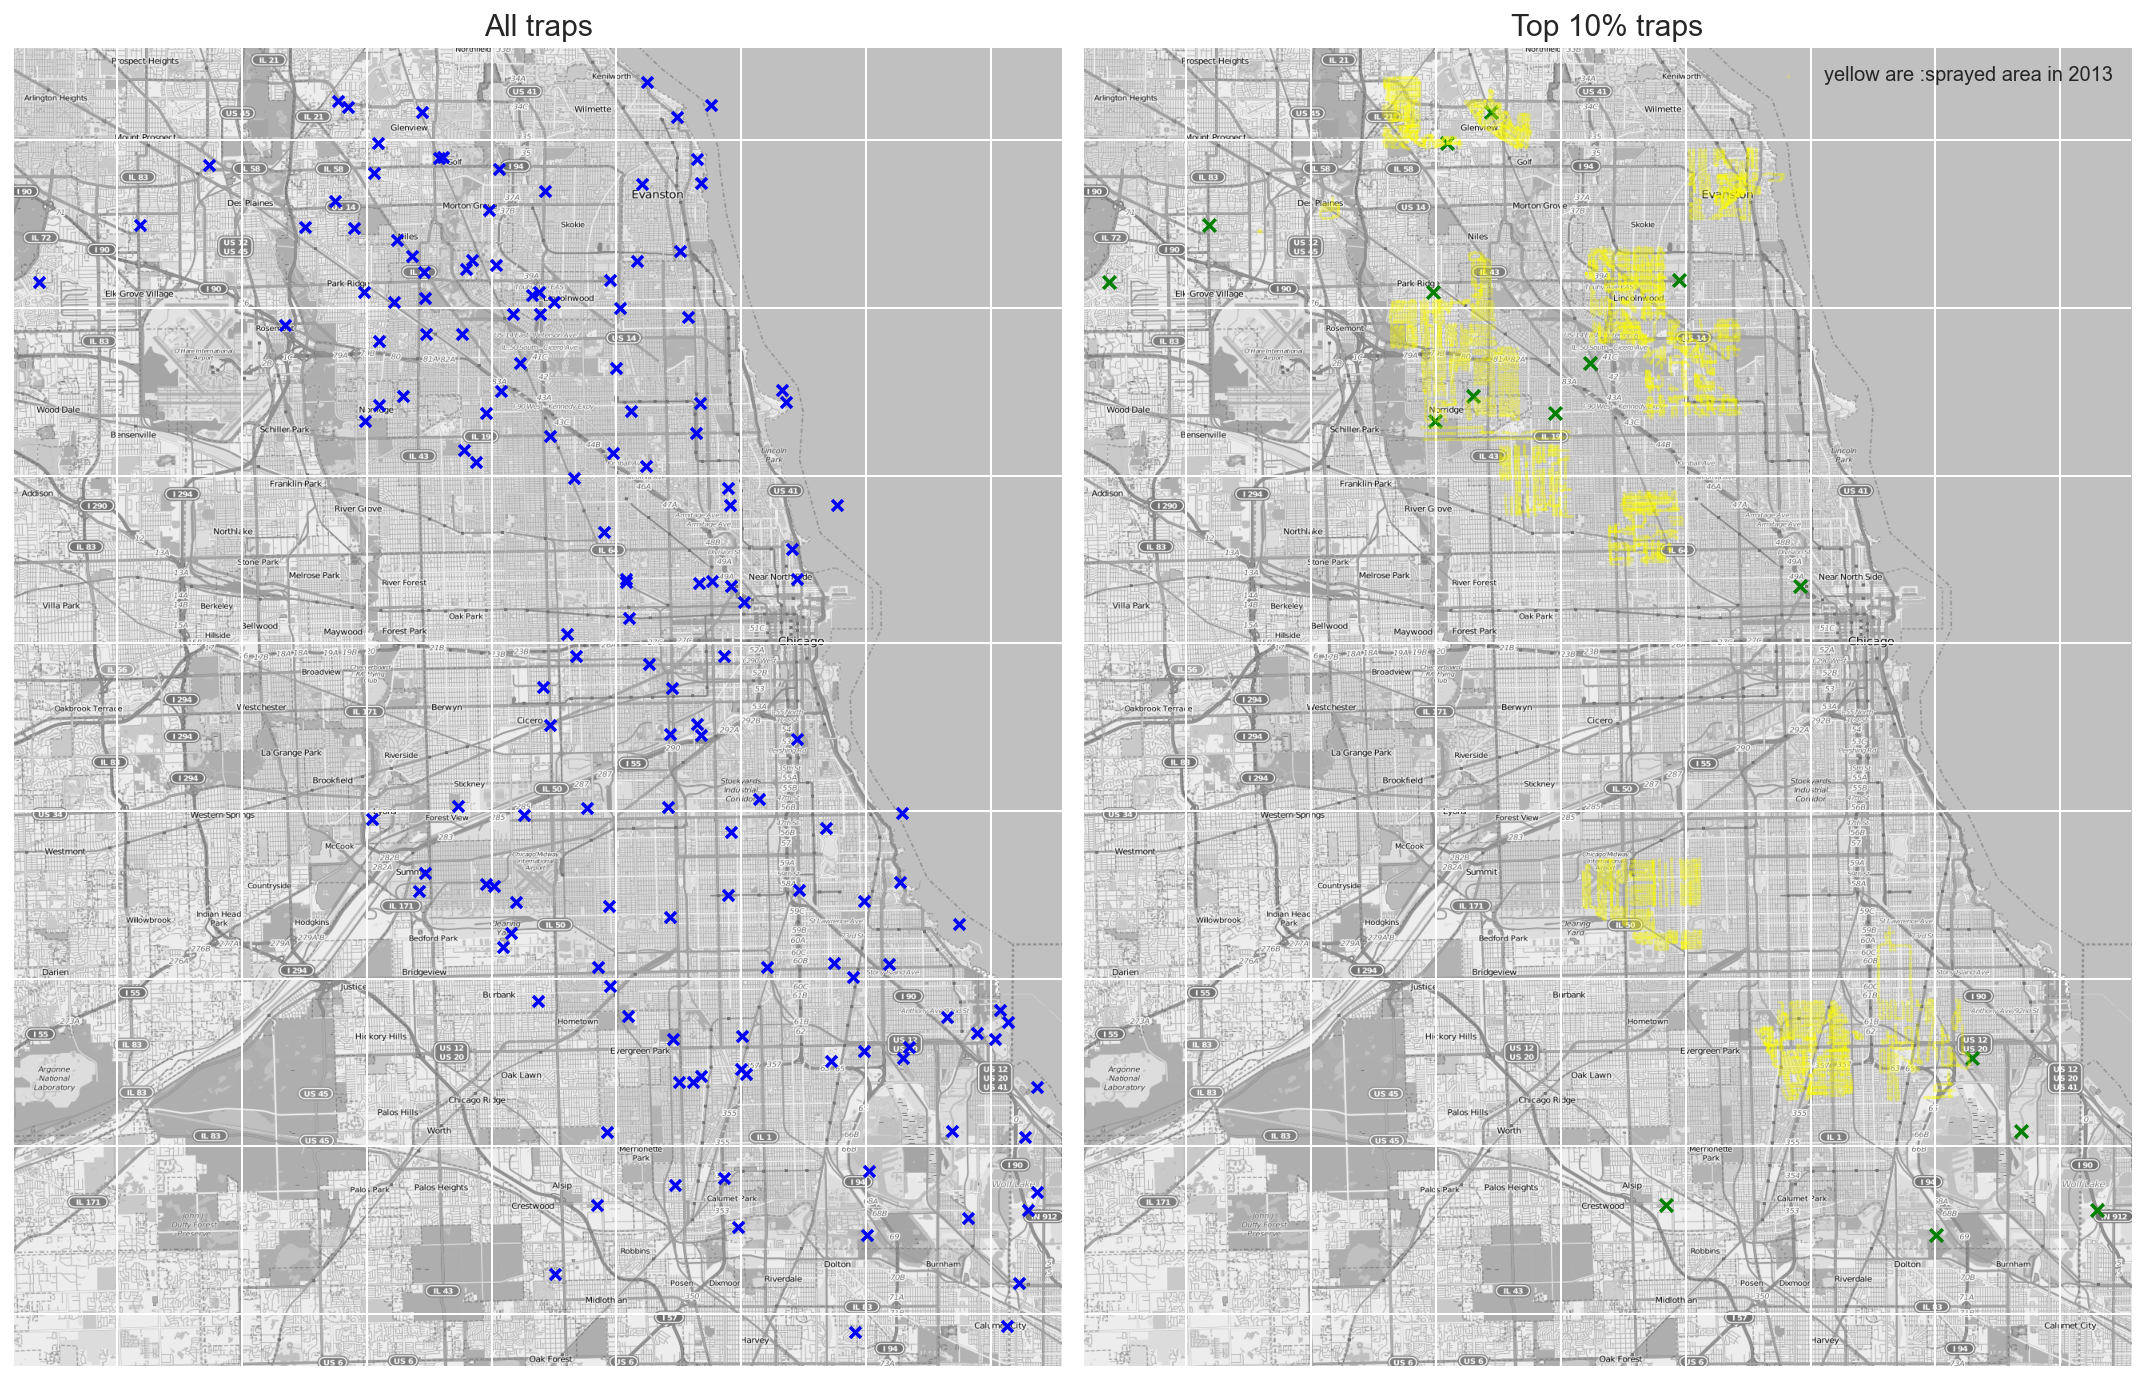

In [36]:
# Visualize the location for the top 10% of WnvPresent
fig, ax = plt.subplots(figsize=(15,10))

for i in range(1,3):
 ax = plt.subplot(1, 2, i)
 plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect
          )
 if i == 1:
   plt.scatter(overall_loca['Longitude'], overall_loca['Latitude'], marker='x', color='blue', s=30)
   plt.title('All traps',size=15)
   ax.set_yticklabels([])
   ax.set_xticklabels([])
 else:
   plt.scatter(overall_loca1['Longitude'], overall_loca1['Latitude'], marker='x', color='green', s=40)
   plt.title('Top 10% traps',size=15)
   ax.set_yticklabels([])
   ax.set_xticklabels([])
spr = df_spray[df_spray['Year']==2013][['Longitude', 'Latitude']].values
plt.scatter(spr[:,0], spr[:,1], marker='o', color='yellow', s=2, label='yellow are :sprayed area in 2013', alpha=0.2)
plt.legend()
#plt.subplots_adjust(hspace=0.5)
plt.tight_layout()  
plt.show()

---

### Conclusion 

The spike of the number of mosquito does not match with any event of spray , we also cannot observe any significant improvement on the weeks after spraying. Besides that, our team will need more data for more detail analysis in the future especially the actual data for the next 12 months after spraying. Hence, we concluded that the effect of spray in 2011 and 2013 are inconculsive. 

However, we are able to provide ideas to target the West Niles Virus base on the trends and data science analysis from our model.


1. The spraying period
   - By looking at the period of coverage of the spray, it was pretty accurate on the peak period of WNV (July - September).But it is still less effective agaisnt the West Nile Virus.
   - As from the historical data, the everage sunrise time in June and July are the earliest and the daytime are the longest.
   - Our team's hypothesis would be:
     a. The mosquito mostly feed on bird during that period due to less human active in earlier daylight
     b. The peak of transmission of virus within the mosquito happen during June to July
     c. While the data shows the mosquito are usually active in the morning (Sunrise)
   - Hence, our team suggest to shift the spray period to `June - August`
   - Cost optimisation - None
   
   
2. The spray location
   - According to our lift curve in section (4.2 Model Evaluation), we have 4 times effective spray at the top 10% location than randomly spray 
   - By targetting on the `top 10% location`,, the cost can reduced to 0.25X.
   - Cost optimisation - `75%`
   
3. The insecticide can be genetically engineered to target the particular species that have the highest possibility of present the virus. The specieses are:
   - `Culex Restuans or Pipiens` . In fact [West Nile virus (WNV) is a mosquito-borne virus that is mainly transmitted among birds by Culex pipiens mosquitoes](https://www.google.com.sg/search?q=culex+pipiens+west+nile+virus&sxsrf=ALiCzsY23ZakuPOphq_JmVI7qg4GMbGwKA%3A1663588995235&source=hp&ei=g1ooY7XWC7GOz7sPoKCcyA4&iflsig=AJiK0e8AAAAAYyhok6xLoULXo5yICWsuvTE-Qwqpq4c6&oq=west+nile+virus+culex+pipens&gs_lcp=Cgdnd3Mtd2l6EAEYADIICAAQHhAIEA0yBQgAEIYDMgUIABCGAzIFCAAQhgM6BAgjECc6CwgAEIAEELEDEIMBOgcIABCxAxBDOgsILhCABBCxAxCDAToFCAAQgAQ6CAgAELEDEIMBOgsILhDHARCvARCRAjoFCAAQkQI6EQguEIAEELEDEIMBEMcBENEDOg4ILhCxAxCDARDHARCvAToICC4Q1AIQkQI6DgguEIAEELEDEMcBEK8BOggIABCABBCxAzoRCC4QgAQQsQMQgwEQxwEQrwE6CwguEIAEELEDENQCOgsILhCABBDHARCvAToFCC4QgAQ6DQguEIAEEMcBEK8BEAo6CAgAEIAEEMkDOgYIABAeEBY6BQghEKABOgQIIRAVUABYulNgzmVoAHAAeACAAZ8BiAHCDpIBBDI1LjOYAQCgAQE&sclient=gws-wiz)
   - The cost saved from spraying on the more critical location can be used in R&D to develope a more effective insecticide. 

---

